# Weather Station Data
## Level 1 QC

In [1]:
#import external libraries
import pandas as pd
import os
pd.options.mode.chained_assignment = None  # default='warn'; chained index warning
import numpy as np
import imp
import datetime
import pytz

#plotting
import seaborn as sns; sns.set(style='whitegrid')
import matplotlib.pyplot as plt
%matplotlib notebook

#import self-written libraries
import LVL1

In [2]:
imp.reload(LVL1)

<module 'LVL1' from 'C:\\Users\\ehbaker\\Documents\\Python\\WXmunge\\LVL1.py'>

** Define Location-Specific Baseline Settings **

In [3]:
#path to level 0 data
Glacier="Wolverine" #or "Gulkana"
Station="990" #or other elevations; this depends on the naming convention of input data
timezone='America/Anchorage' #choose from pytz.all_timezones
pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL0/" + Glacier.lower()+"_990_ALL_15minLVL0.csv"
#pth=r"Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\LVL0\emily\wolverine990_2017_15minL0.csv"
#time format and column
UTC_time_column_name='UTC_time'
date_format='%Y/%m/%d %H:%M'

#directory to save output data
save_pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL1/emily/" + Glacier.lower()+"_990_ALL_15minLVL1.csv"

### Data import
- read in data 
- set timezone
- set time as index

In [4]:
#read in level0 CSV
dat=pd.read_csv(pth)

In [5]:
#TIME SHOULD BE DEALT WITH IN LEVEL0 PROCESSING (aka before this); LEVEL 0 will have time in UTC.
#I'm doing it here because it is currently NOT; shift this block to level 0 processing when possible.
dat['time']=pd.to_datetime(dat[UTC_time_column_name], format= date_format) #this is not actually UTC time; it's UTC-8
dat['UTC']=dat.time + datetime.timedelta(hours=8) #This is now UTC time #THIS NAME MUST BE USED!

dat['UTC']=dat.UTC_time

#Convert date to date-time object, and index of dataframe
dat['UTC']=pd.to_datetime(dat.UTC, format=date_format)
dat=dat.set_index("UTC") #Set this UTC time object as the index of the dataframe

#Timezone
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)
dat['local_time'] = dat.index.tz_localize('UTC').tz_convert(local_timezone)
dat=dat.set_index('local_time')

#Create QC-Flag identical dataframe - will store QC status of each value
dat_qc_info = pd.DataFrame().reindex_like(dat)

Station-specific Data Adjustments

In [6]:
# Wolverine990: Prior to 2014.04.20, asp. temperature only aspirated on the hour; other msmts set to NAN
if Glacier+Station=="Wolverine990":
    dat.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=np.nan
    dat_qc_info.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=1 #seet QC flag to 1, indicating removed values
    dat.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=np.nan
    dat_qc_info.loc[(dat.index>'2014/04/20 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=1

# Remove this subset after done troubleshooting!!

In [7]:
#Subset to 3 months, for speed during trouble-shoot
precip_columns=['TPGCumulative', 'StageCumulative']

dat=dat['2013-01':'2013-03']
for precip_col in precip_columns:
    dat[precip_col]=dat[precip_col]-dat[precip_col][0] #set series so that it begins at 0; only neccesary for subsets

** Remove malfunctioning sensors manually **
* done separately for each timestep entered on look-up table

In [8]:
#read in table listing sensors and timeperiods that need to be modified
pth_bad_sensor_dates=r"Q:\Project Data\GlacierData\Benchmark_Program\Metadata\weather"
bad_sensor_dates_dat=pd.read_excel(os.path.join(pth_bad_sensor_dates, Glacier+Station+"_SensorLog.xlsx"))

#Set bad data to NAN. Move sensor data to correct column, if neccessary.
dat=LVL1.remove_malfunctioning_sensor_data(dat, bad_sensor_dates_dat)
print("Removed:")
bad_sensor_dates_dat

Removed:


,Sensor,Start_Date,End_Date,Action,Correct_Label,Location
0,TAspirated2,2014-04-25 06:45:00,2014-09-04 09:00:00,switch_label,Tpassive2,Wolverine990
1,Tpassive1,2013-05-07 02:15:00,2013-11-06 08:00:00,bad,NaN,Wolverine990
2,Tpassive2,2013-11-06 08:00:00,2014-09-04 09:15:00,bad,NaN,Wolverine990
3,Tpassive2,2016-07-12 16:00:00,2016-08-18 03:59:00,bad,NaN,Wolverine990
4,TPGCumulative,2015-03-16 17:00:00,2015-03-19 00:00:00,bad,NaN,Wolverine990


** Set hard-coded cutoff values** (station specific)

In [9]:
if Glacier+Station=="Wolverine990":
    low_temp_cutoff=-40.0 #deg. C
    high_temp_cutoff=30.0

    precip_high_cutoff=0.015 #meters
    precip_drain_cutoff=-0.015
    obvious_error_precip_cutoff=0.3 #if 30 cm in 15 minutes, obviously an error.
    
    Stage_dies='2015/09/01 06:30:00' #time at which instrument was removed
    TPG_born='2012/10/02 00:00:00' #time at which instrument was removed

** Clean Temperature Data**

In [10]:
#Temperature
temp_columns=['Tpassive1', 'Tpassive2', 'TAspirated1', 'TAspirated2']
for temp_col in temp_columns:
    temps=dat.loc[:,temp_col]
    dat.loc[:,temp_col]=LVL1.remove_error_temperature_values(temps, low_temp_cutoff, high_temp_cutoff)

#### Plot temperature data, before and after

** Plot original precipitation data**

<IPython.core.display.Javascript object>


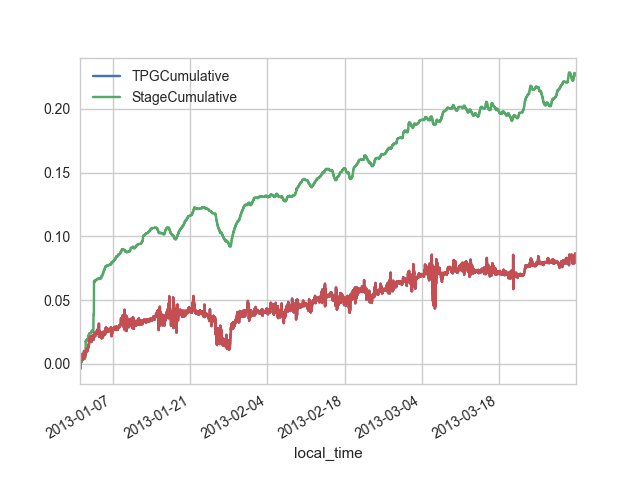

In [11]:
#Precip
precip_columns=['TPGCumulative', 'StageCumulative']
precip_column_basenames=[precip_col.split("Cumulative")[0] for precip_col in precip_columns]

dat_original=dat.copy() #save unaltered data for later comparrison
dat_original[precip_columns].plot()

** Clean Precipitation Data **

In [12]:
#Set gages to NAN, when not installed (single gauge style does not cover period of record)
for precip_col in precip_columns:
    if 'TPG' in precip_col.upper():
        dat.loc[:TPG_born, precip_col]=np.nan
    if 'stage' in precip_col.lower():
        dat.loc[Stage_dies:, precip_col]=np.nan

In [30]:
OG_stuff=dat.TPGCumulative.copy()

In [43]:
#Remove Out of Range Data Values
for precip_col in precip_columns:
    dat.loc[:,precip_col]=LVL1.precip_remove_obvious_sensor_malfunctions(dat[precip_col], obvious_error_precip_cutoff)

In [42]:
imp.reload(LVL1)

<module 'LVL1' from 'C:\\Users\\ehbaker\\Documents\\Python\\WXmunge\\LVL1.py'>

In [56]:
#Remove Spikes from Incremental Data - Nayak part 1
# THIS IS WORSE THSN EVERYTHING BEFORE!
new_crap=LVL1.precip_remove_high_frequency_noiseNayak2010(OG_stuff, noise=.0021, bucket_fill_drain_cutoff=0.2)

interpolated noise at locations 2:8
single value removed at 8
interpolated noise at locations 22:29
single value removed at 29
interpolated noise at locations 53:57
single value removed at 57
interpolated noise at locations 239:244
single value removed at 244
single value removed at 309
interpolated noise at locations 329:333
single value removed at 333
single value removed at 341
single value removed at 353
interpolated noise at locations 376:377
single value removed at 377
interpolated noise at locations 384:385
single value removed at 385
interpolated noise at locations 393:394
single value removed at 394
single value removed at 403
interpolated noise at locations 551:555
single value removed at 555
single value removed at 605
interpolated noise at locations 745:756
single value removed at 756
interpolated noise at locations 772:792
single value removed at 792
interpolated noise at locations 798:816
single value removed at 816
interpolated noise at locations 829:848
single value rem

In [52]:
incr[374]

-0.0014000000000000679

<IPython.core.display.Javascript object>


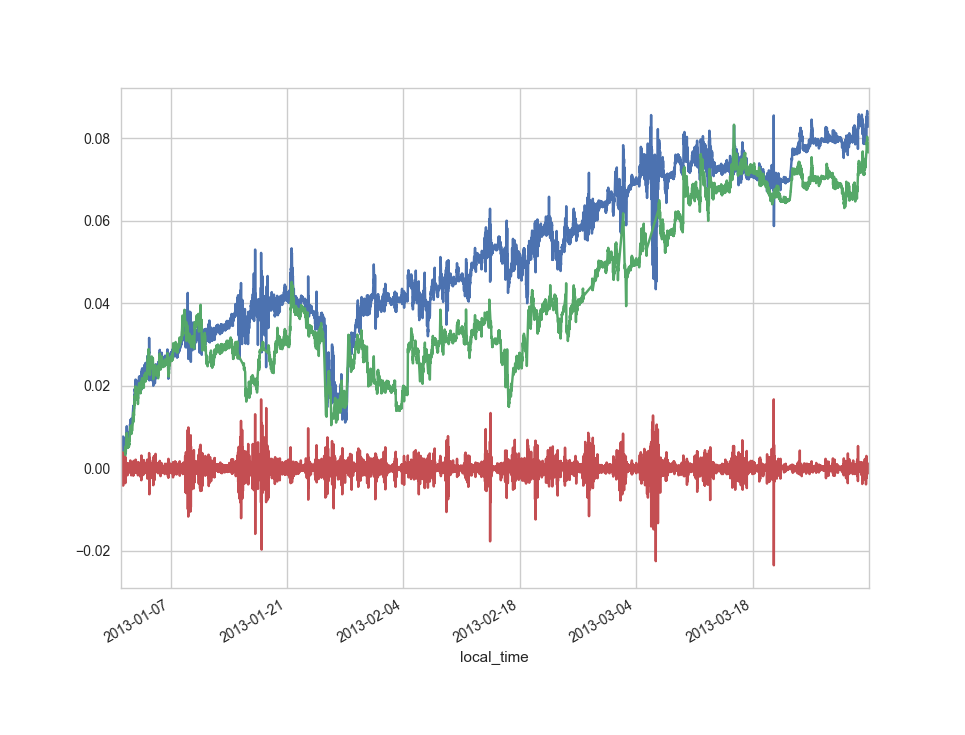

In [57]:
ax=OG_stuff.plot()
new_crap.plot(ax=ax)
incr.plot(ax=ax)

# Create Incremental Precip Series

In [13]:
incremental_precip_columns=[] #store names of incremental precip columns
for precip_col_base in precip_column_basenames:
    col_name=precip_col_base+"Incremental"
    incremental_precip_columns.append(col_name)
    dat[col_name]=dat[precip_col_base+"Cumulative"]-dat[precip_col_base+"Cumulative"].shift(1)
    dat[precip_col_base+"Incremental"][0]=0 #set first value to 0, not NAN

### Edit Incremental Precip Series

In [14]:
#Remove short-duration sensor malfunctions with rolling median-based filter, and static instantaneous threshold (cumulative data)
# - input - cumulative timeseries
# - output - incremental data with outliers removed (timestep set to 0)
for base_col in precip_column_basenames:
    dat.loc[:,base_col+"Incremental"]=LVL1.basic_median_outlier_strip(dat[base_col +"Cumulative"], k=7, threshold=0.005) #7 gives the sample, and 3 on either side (6-sample filter); 0.5 cm threshold (0.005 m)

In [15]:
plot_dat=pd.DataFrame()
for base_col in precip_column_basenames:
    plot_dat[base_col]=LVL1.calculate_cumulative(cumulative_vals_orig=dat[base_col + "Cumulative"], incremental_vals=dat[base_col+ "Incremental"])

<IPython.core.display.Javascript object>


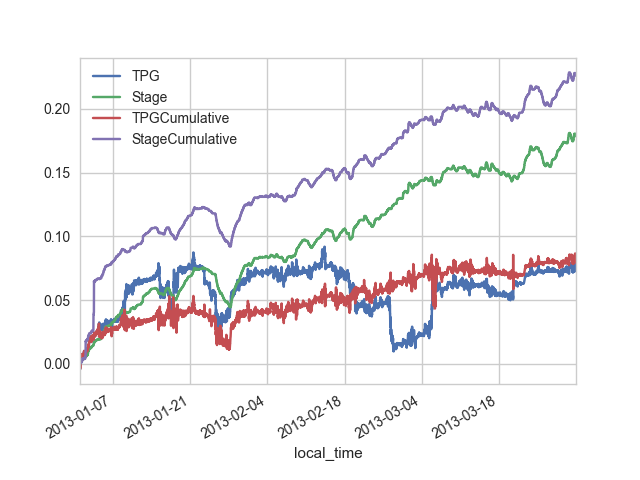

In [16]:
%matplotlib notebook
ax=plot_dat.plot()
dat_original[precip_columns].plot(ax=ax)

<IPython.core.display.Javascript object>


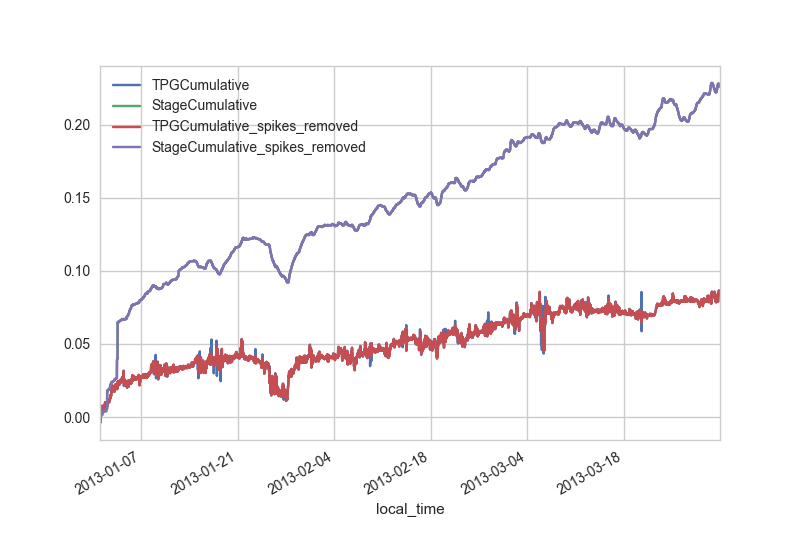

In [45]:
#Plot this initial error removal
data_spikes_removed=dat.copy()
data_spikes_removed=LVL1.rename_pandas_columns_for_plotting(data_spikes_removed, precip_columns, "_spikes_removed") #save this data for later plotting
ax=dat_original[precip_columns].plot()
data_spikes_removed.plot(ax=ax)

<IPython.core.display.Javascript object>


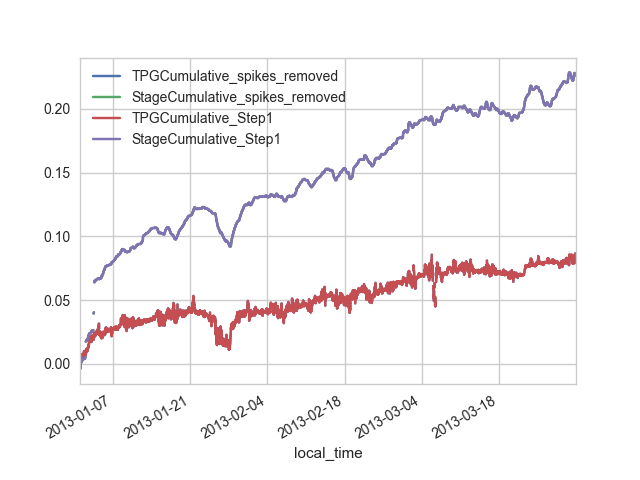

In [15]:
#Remove large instantaneous jumps
for precip_col in precip_columns:
    dat.loc[:,precip_col]=LVL1.precip_remove_obvious_sensor_malfunctions(dat[precip_col], obvious_error_precip_cutoff)

#Save data for plotting
data_obv_errors_removed=dat.copy()

#Plot
data_obv_errors_removed=LVL1.rename_pandas_columns_for_plotting(data_obv_errors_removed, precip_columns, "_Step1") #save this data for later plotting
ax=data_spikes_removed.plot()
data_obv_errors_removed.plot(ax=ax)

In [109]:
#Remove Outliers that remain on full-day interval (neccesary for spikes that last > 7 msmts)
for precip_col in precip_columns:
    dat[precip_col]=LVL1.precip_remove_daily_outliers(dat[precip_col])

In [110]:
# #Interpolate Gaps < 1 day in cumulative record
# for precip_col in precip_columns:
#     dat[precip_col]=LVL1.precip_interpolate_gaps_under1day(dat[precip_col])

#### Remove Incremental Values over set cutoffs

In [111]:
#Remove values from incremental timeseries that exceed set cutoff values
incremental_precip_columns=[] # Create empty list
for precip_col in precip_columns:
    dPrecip_col_name=precip_col.split("Cumulative")[0]+ "Incremental" #create name for new incremental column
    dat[dPrecip_col_name]=LVL1.precip_remove_maintenance_noise(dat[precip_col], obvious_error_precip_cutoff, precip_high_cutoff, precip_drain_cutoff)
    incremental_precip_columns.append(dPrecip_col_name) #add column name to incremental precip list

In [115]:
# ax=dat[precip_columns].plot()
# dat[incremental_precip_columns].cumsum().plot(ax=ax)
# #dat['2013-02-14':'2013-02-16'][precip_columns].plot()

<IPython.core.display.Javascript object>


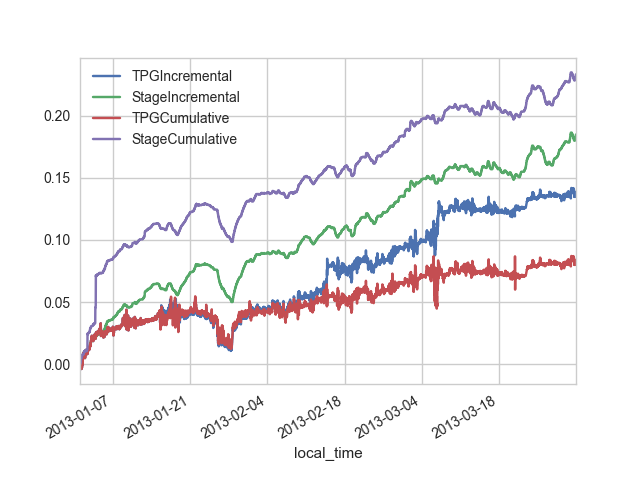

In [39]:
ax=dat[incremental_precip_columns].cumsum().plot()
dat_original[precip_columns].plot(ax=ax)

In [116]:
# ax=precip_incremental.cumsum().plot()
# dat_original[precip_columns].plot(color=['black'], linewidth=0.5, ax=ax)
# new.cumsum().plot(ax=ax, color=['pink'])

## Re-calculate cumulative timeseries

In [125]:
for incr_col in incremental_precip_columns:
    incremental_vals=dat[incr_col].copy() #incremental values
    cum_col_name=incr_col.split("Incremental")[0]+ "Cumulative" #create name for new incremental column
    #Calculate cumulative sum of incremental values
    new_cumulative=incremental_vals.cumsum()
    new_cumulative = new_cumulative + vals[0]
    new_cumulative[0]=vals[0]
    #Store in dataframe under correct name (cum_col_name)
    dat[cum_col_name]=new_cumulative
    print(cum_col_name)

TPGCumulative
StageCumulative


<IPython.core.display.Javascript object>


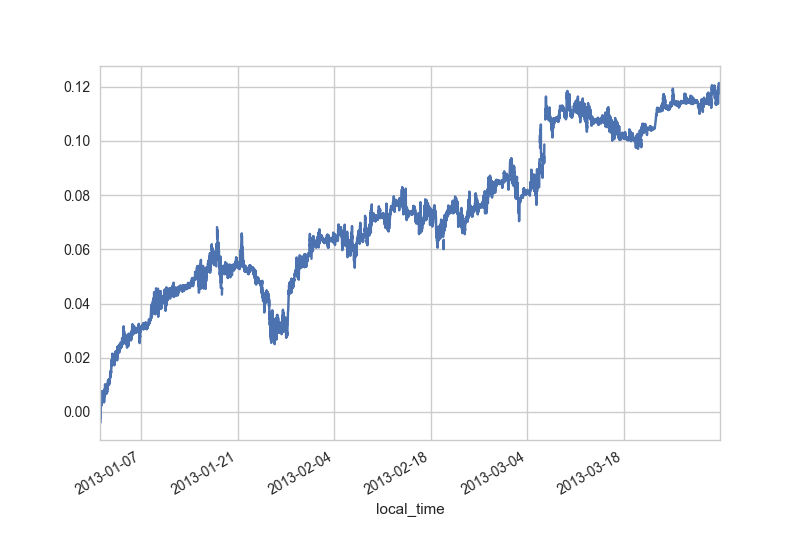

In [127]:
%matplotlib notebook
dat.TPGCumulative.plot()

### Interpolate gaps in cumulative timeseries

In [ ]:
#Interpolate Gaps < 1 day in cumulative record
for precip_col in precip_columns:
    dat[precip_col]=LVL1.precip_interpolate_gaps_under1day(dat[precip_col])

### Re-create incremental timeseries for smoothing

In [ ]:
for incr_col in incremental_precip_columns:
    dat[incr_col]=

**Smooth Data with method from Nayak (2010): **

In [32]:
#Smooth Incremental Precip Data
for incr_precip_col in incremental_precip_columns:
    #Smooth this data with method from Nayak 2010
    print ("smoothing "+ incr_precip_col)
    dat=LVL1.smooth_precip_Nayak2010(dat, incr_precip_col)

smoothing TPGIncremental
  smoothing data in forward direction; may take a minute
  smoothing data in reverse direction; may take a minute
smoothing StageIncremental
  smoothing data in forward direction; may take a minute
  smoothing data in reverse direction; may take a minute


** Plot Data After Smoothing **

In [120]:
smoothed_columns=[s + "_smooth" for s in incremental_precip_columns] #names of columns post-smoothing
ax=dat[incremental_precip_columns+smoothed_columns].cumsum().plot()
dat_original[precip_columns].plot(color=['black'], linewidth=0.5, ax=ax)

KeyError: "['TPGIncremental_smooth' 'StageIncremental_smooth'] not in index"

In [32]:
#Convert units from meters to mm
for col in smoothed_columns:
    dat.loc[:,col]=dat[col]*1000

In [33]:
#Set no-data values before TPG installed, and after rocket removed to NAN (not 0)
for precip_col in smoothed_columns:
    if 'TPG' in precip_col.upper():
        dat.loc[:TPG_born, precip_col]=np.nan
    if 'stage' in precip_col.lower():
        dat.loc[Stage_dies:, precip_col]=np.nan

## Save Edited Data

In [34]:
#Time
dat['Local_time']=dat.index.tz_convert(local_timezone).strftime(date_format)#Create column for true local time (as string, not UTC - X hrs)
#Column Names
out_columns=['Local_time']+temp_columns+smoothed_columns+['RelHum', 'WindSpeed', 'WindGustSpeed', 'WindDir', 'LoggerTemp','LoggerBattery']
#Subset
save_dat=dat[out_columns] #removes unwanted columns
#Rename columns with "smooth" in them; match original naming
for col in smoothed_columns:
    newname=col.strip("_smooth")
    save_dat.rename(index=str, columns={col: newname}, inplace=True)

#Save
save_dat.to_csv(save_pth, index=False, float_format='%g')

In [44]:
vals=pd.Series(np.random.randn(250000))

In [50]:
diff=vals-vals.shift(1)

209234098234421.34

In [45]:
#Original values in cumulative series
vals=pd.Series(np.random.randn(250000).cumsum())

#Calculate incremental change
incremental_vals=vals-vals.shift(1) #calculate incremental changes

#Calculate cumulative sum of incremental values
new_cumulative=incremental_vals.cumsum()

new_cumulative = new_cumulative + vals[0]
new_cumulative[0]=vals[0]

In [106]:
%qtconsole